___

<a href='http://www.dourthe.tech'> <img src='Dourthe_Technologies_Headers.png' /></a>
___
<center><em>For more information, visit <a href='http://www.dourthe.tech'>www.dourthe.tech</a></em></center>

# Credit Card Fraud Prediction using Logistic Regression

___ 
## Objective
Train a Logistic Regression model to identify fraudulent credit card transactions.

 ___
## Dataset
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The dataset can be found at: https://www.kaggle.com/mlg-ulb/creditcardfraud

___
## Libraries Imports
### Data manipulation and analysis

In [1]:
import pandas as pd
import numpy as np

### Data visualization

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Machine learning

In [61]:
# Create new synthetic points in an unbalanced dataset using the Synthetic Minority Over-sampling Technique (SMOTE)
from imblearn.over_sampling import SMOTE

# Split data between training and test set
from sklearn.model_selection import StratifiedKFold

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Create a pipeline for imbalanced datasets
from imblearn.pipeline import make_pipeline

# Support vector machine classifier
from sklearn.linear_model import LogisticRegression

# Cross-validation
from sklearn.model_selection import RandomizedSearchCV

# Model save
import pickle

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

___
## Data Import

In [5]:
df = pd.read_csv('credit_card_fraud.csv')

___
## Exploratory Data Analysis
### General

**Display the first few rows of the dataset.**

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Missing data
**Check for missing data (expressed as a percentage of the dataset length).**

In [7]:
df.isnull().sum().max()*100/len(df)

0.0

**Thankfully, there are no missing data!**

### Data imbalance

**Let's compare the number of observations for each class.**

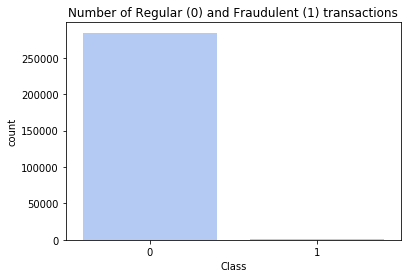

In [8]:
sns.countplot('Class', data=df, palette='coolwarm')
plt.title('Number of Regular (0) and Fraudulent (1) transactions')
plt.show()

As mentioned in the description of the dataset, it is extremely unbalanced.

**Let's calculate the ratio between classes to better understand the imbalance.**

In [9]:
valuecount = df['Class'].value_counts()*100/len(df)
print('Percentage of non-fraudulent transactions:\t', valuecount[0].round(2), '%')
print('Percentage of fraudulent transactions:\t\t', valuecount[1].round(2), '%')

Percentage of non-fraudulent transactions:	 99.83 %
Percentage of fraudulent transactions:		 0.17 %


With such a large imbalance, most classifiers would not be able to detect distinguishing patterns between non-fraudulent and fraudulent transactions.

___
## Machine Learning
**To account for the large imbalance of the dataset, we will use cross-validation combined with the Synthetic Minority Over-sampling Technique (SMOTE).**
### Input/Output definition

In [45]:
X = df.drop('Class', axis=1)
y = df['Class']

### Train/Test split
**Instead of using the usual train_test_split function from SciKit.Learn, we will use the StratifiedKFold method.**
This cross-validation technique is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [46]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

**Compare original label distribution to train/test split label distribution.**

In [47]:
_, original_labels_count = np.unique(y, return_counts=True)
original_dist = np.round(original_labels_count/len(y)*100, 2)
_, train_labels_count = np.unique(y_train, return_counts=True)
train_dist = np.round(train_labels_count/len(y_train)*100, 2)
_, test_labels_count = np.unique(y_test, return_counts=True)
test_dist = np.round(test_labels_count/len(y_test)*100, 2)

print('LABELS DISTRIBUTION')
print('\tOriginal:\t\t', original_dist[0], '% (label 0)\t', original_dist[1], '% (label 1)')
print('\tTraining set:\t\t', train_dist[0], '% (label 0)\t', train_dist[1], '% (label 1)')
print('\tTest set:\t\t', test_dist[0], '% (label 0)\t', test_dist[1], '% (label 1)')

LABELS DISTRIBUTION
	Original:		 99.83 % (label 0)	 0.17 % (label 1)
	Training set:		 99.83 % (label 0)	 0.17 % (label 1)
	Test set:		 99.83 % (label 0)	 0.17 % (label 1)


### Data scaling
**To prevent the potential impact of higher weights from variables that have larger ranges of values, we need to scale the data.**

We can start by defining a scaler and fitting it to the training data.

_Warning: do not fit the scaler to the test data, as in a real life scenario we would not be able to fit the scaler to the testing data._

In [48]:
scaler = MinMaxScaler()

In [49]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

**Now, we can transform the training and test data.**

Note: no need to transform the label data.

In [50]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train, y_test = y_train.values, y_test.values

### Define and fit model to training data
**First, we need to define a grid of parameters that will be used during cross-validation.**

In [51]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

**Next, we will define an instance of RandomizedSearchCV using LogisticRegression as the estimator.**

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter. This will allow the training to be a little more efficient.

In [52]:
randomized_logR = RandomizedSearchCV(LogisticRegression(max_iter=300), param_grid, n_iter=4)

**Now, we will create a loop that will iterate through each fold generated by the StratifiedKFold method and create a pipeline that will apply the SMOTE method to the dataset and run our defined classifier.**

_Note: a variety of evaluation scores will be saved throughout the process._

In [54]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Implementing SMOTE Technique 
for train, test in skf.split(X_train_scaled, y_train):
    pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), randomized_logR)
    model = pipeline.fit(X_train_scaled[train], y_train[train])
    best_model = randomized_logR.best_estimator_
    predictions = best_model.predict(X_train_scaled[test])    

    accuracy_lst.append(pipeline.score(X_train_scaled[test], y_train[test]))
    precision_lst.append(precision_score(y_train[test], predictions))
    recall_lst.append(recall_score(y_train[test], predictions))
    f1_lst.append(f1_score(y_train[test], predictions))
    auc_lst.append(roc_auc_score(y_train[test], predictions))

c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

**Save the model.**

In [62]:
filename = 'credit_card_fraud_predictor.sav'
pickle.dump(model, open(filename, 'wb'))

### Model evaluation
**First, let's print the mean evaluation scores.**

In [55]:
print('MODEL EVALUATION')
print('\tMean accuracy:\t',  np.round(np.mean(accuracy_lst), 2))
print('\tMean precision:\t', np.round(np.mean(precision_lst), 2))
print('\tMean recall:\t', np.round(np.mean(recall_lst), 2))
print('\tMean f1-score:\t', np.round(np.mean(f1_lst), 2))

MODEL EVALUATION
	Mean accuracy:	 0.96
	Mean precision:	 0.07
	Mean recall:	 0.91
	Mean f1-score:	 0.13


**Then, we will generate predictions using the best model generated during cross-validation:**

In [56]:
predictions = best_model.predict(X_test_scaled)

**Evaluate the model using classification report and confusion matrix:**

In [57]:
cm = confusion_matrix(y_test, predictions)
print('CONFUSION MATRIX\n')
print('Total number of')
print('\tTrue positives:\t\t', cm[1,1])
print('\tTrue negatives:\t\t', cm[0,0])
print('\tFalse positives:\t', cm[0,1], '\t\tType I error')
print('\tFalse negatives:\t', cm[1,0], '\t\tType II error')
print('\n')
print('Correct classifications:\t', np.round(100*(cm[0,0]+cm[1,1])/len(X_test),2), '%')
print('Incorrect classifications:\t', np.round(100*(cm[1,0]+cm[0,1])/len(X_test),2), '%')
print('\nCLASSIFICATION REPORT\n')
print(classification_report(y_test, predictions))

CONFUSION MATRIX

Total number of
	True positives:		 84
	True negatives:		 56325
	False positives:	 538 		Type I error
	False negatives:	 14 		Type II error


Correct classifications:	 99.03 %
Incorrect classifications:	 0.97 %

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.14      0.86      0.23        98

    accuracy                           0.99     56961
   macro avg       0.57      0.92      0.61     56961
weighted avg       1.00      0.99      0.99     56961



**Finally, we can also look at the average precision-recall score and precision-recall curve:**

In [58]:
average_precision = average_precision_score(y_test, predictions)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.12


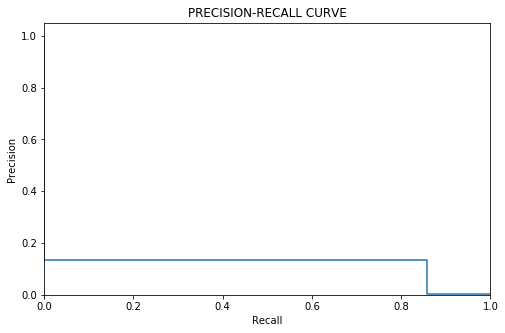

In [63]:
precision = dict()
recall = dict()
precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.figure(figsize=(8,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PRECISION-RECALL CURVE')
plt.show()

___
## Conclusion

The Logistic Regression model performed very well in terms of recall score for both fraudulent and non-fraudulent transactions. Also, most incorrect predictions turned out to be False Positives, which remain much better than False Negatives. Indeed, it is largely preferable to predict a False Positive, which would then allow an agent to perform a deeper investigation and find out whether that transaction was actually fraudulent or not. 

The overall precision of the model could still be improved, either by decreasing the imbalance of the dataset (i.e. by including more fraudulent transactions), or by testing other classification approaches (e.g. Support Vector Machine, Artificial Neural Network).

**This pipeline could easily be transferred to other logistic regression problems.**